In [53]:
source("HulC.R")
library("sandwich")
library(ggplot2)
library("cowplot")
library("gridExtra")
library("repr")

In [20]:
## The following function generates data from a 
## misspecified linear model and constructs both
## HulC and Wald confidence intervals. The model
## is 
## Y = 1 + 2*x + gamma*x^{1.7} + exp(gamma*x)*epsilon.
## For gamma = 0, the model is well-specified.
foo <- function(nsamp, gamma, name, alpha = 0.05){
    beta0 <- 1
    beta1 <- 2
    x <- runif(nsamp, 0, 10)
    y <- beta0 + beta1*x + gamma*x^{1.7} + exp(gamma*x)*rnorm(nsamp)
    data <- cbind(x, y)
    if(name == "HulC"){
        estimate <- function(dat_tmp){
            fit <- lm(dat_tmp[,2] ~ dat_tmp[,1])
            return(unname(fit$coeff)[2])
        }
        tmp <- as.vector(HulC(data, estimate, alpha = alpha, Delta = 0, dim = 1)$CI)
    }
    if(name == "Wald"){
        mod <- lm(data[,2] ~ data[,1])
        est <- unname(mod$coeff[2])
        sd_est <- sqrt(vcovHC(mod, type = "HC")[2,2])
        tmp <- est + c(-1, 1)*qnorm(1-alpha/2)*sd_est
    }
    return(tmp)
}

## HulC confidence interval
print("HulC confidence interval:")
foo(100, 0, "HulC", alpha = 0.05)

## Wald confidence interval
print("Wald confidence interval:")
foo(100, 0, "Wald", alpha = 0.05)

[1] "HulC confidence interval:"


[1] 1.930130 2.110275

[1] "Wald confidence interval:"


[1] 1.944472 2.103495

In [41]:
nsamp_seq <- c(20, 50, 100, 1000)
gamma_seq <- seq(0, 1, length = 5)
## Finding the projection parameter values using 
## Monte Carlo simulation
proj_beta <- rep(0, length(gamma_seq))
names(proj_beta) <- paste0("gamma_", gamma_seq)
# for(idx in 1:length(gamma_seq)){
#   beta0 <- 1
#   beta1 <- 2
#   nsamp <- 1e08
#   gamma <- gamma_seq[idx]
#   x <- runif(nsamp, 0, 10)
#   y <- beta0 + beta1*x + gamma*x^{1.7} + exp(gamma*x)*rnorm(nsamp)
#   data <- cbind(1, x, y)
#   proj_beta[idx] <- unname(lm.fit(data[,c(1,2)], data[,3])$coefficients[2])
# }
## proj_beta vector is
## 2.000038 3.279129 4.556705 5.823864 6.809289 
proj_beta <- c(2.000038, 3.279129, 4.556705, 5.823864, 6.809289)
names(proj_beta) <- paste0("gamma_",gamma_seq)

## Simulation
## Setting seed for reproducibility.
set.seed(2021)
name_seq <- c("HulC", "Wald")
nrep <- 1000
rep_seq <- 1:nrep
grid <- expand.grid(nsamp_seq, gamma_seq, name_seq, rep_seq)
colnames(grid) <- c("nsamp", "gamma", "name", "rep")
width_mat <- data.frame(value = rep(0, nrow(grid)), gamma = grid$gamma, nsamp = grid$nsamp, name = grid$name, rep = grid$rep)
cov_mat <- width_mat

for(idx in 1:nrow(grid)){
    if(idx%%1000 == 0){
      print(idx)
    }
    tmp <- foo(grid[idx,1], grid[idx,2], grid[idx,3], alpha = 0.05)
    width_mat[idx, 1] <- (tmp[2] - tmp[1])
    true_beta <- proj_beta[paste0("gamma_", grid[idx,2])]
    cov_mat[idx, 1] <- (tmp[1] <= true_beta && true_beta <= tmp[2])
}

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000


value,gamma,nsamp,name,rep
1,0.00,20,HulC,1
1,0.00,50,HulC,1
1,0.00,100,HulC,1
1,0.00,1000,HulC,1
1,0.25,20,HulC,1
1,0.25,50,HulC,1


In [42]:
head(cov_mat)
grid_new <- expand.grid(nsamp_seq, gamma_seq, name_seq)
colnames(grid_new) <- c("nsamp", "gamma", "name")
col.cov<- data.frame(cov = rep(0, nrow(grid_new)), gamma = grid_new$gamma, nsamp = grid_new$nsamp, name = grid_new$name)
for(idx in 1:nrow(grid_new)){
  temp.width <- cov_mat[cov_mat$nsamp==grid_new[idx,"nsamp"],]
  temp.width1 <- temp.width[temp.width$gamma==grid_new[idx,"gamma"],]
  temp.width2 <- temp.width1[temp.width1$name==grid_new[idx,"name"],]
  col.cov[idx,1] <- mean(temp.width2$value)
}
col.cov$type <- "Coverage"
new_width_mat <- width_mat[width_mat$name == "HulC",]
new_width_mat$value <- new_width_mat$value/width_mat[width_mat$name == "Wald",1]
tmp_width_mat <- new_width_mat[new_width_mat$value <= 20,]
tmp_width_mat$type <- "Width Ratio"

head(col.cov)
head(tmp_width_mat)

value,gamma,nsamp,name,rep
1,0.00,20,HulC,1
1,0.00,50,HulC,1
1,0.00,100,HulC,1
1,0.00,1000,HulC,1
1,0.25,20,HulC,1
1,0.25,50,HulC,1


cov,gamma,nsamp,name,type
0.950,0.00,20,HulC,Coverage
0.951,0.00,50,HulC,Coverage
0.956,0.00,100,HulC,Coverage
0.956,0.00,1000,HulC,Coverage
0.952,0.25,20,HulC,Coverage
0.948,0.25,50,HulC,Coverage


value,gamma,nsamp,name,rep,type
2.966502,0.00,20,HulC,1,Width Ratio
1.068702,0.00,50,HulC,1,Width Ratio
2.006350,0.00,100,HulC,1,Width Ratio
2.016145,0.00,1000,HulC,1,Width Ratio
5.003359,0.25,20,HulC,1,Width Ratio
3.262480,0.25,50,HulC,1,Width Ratio


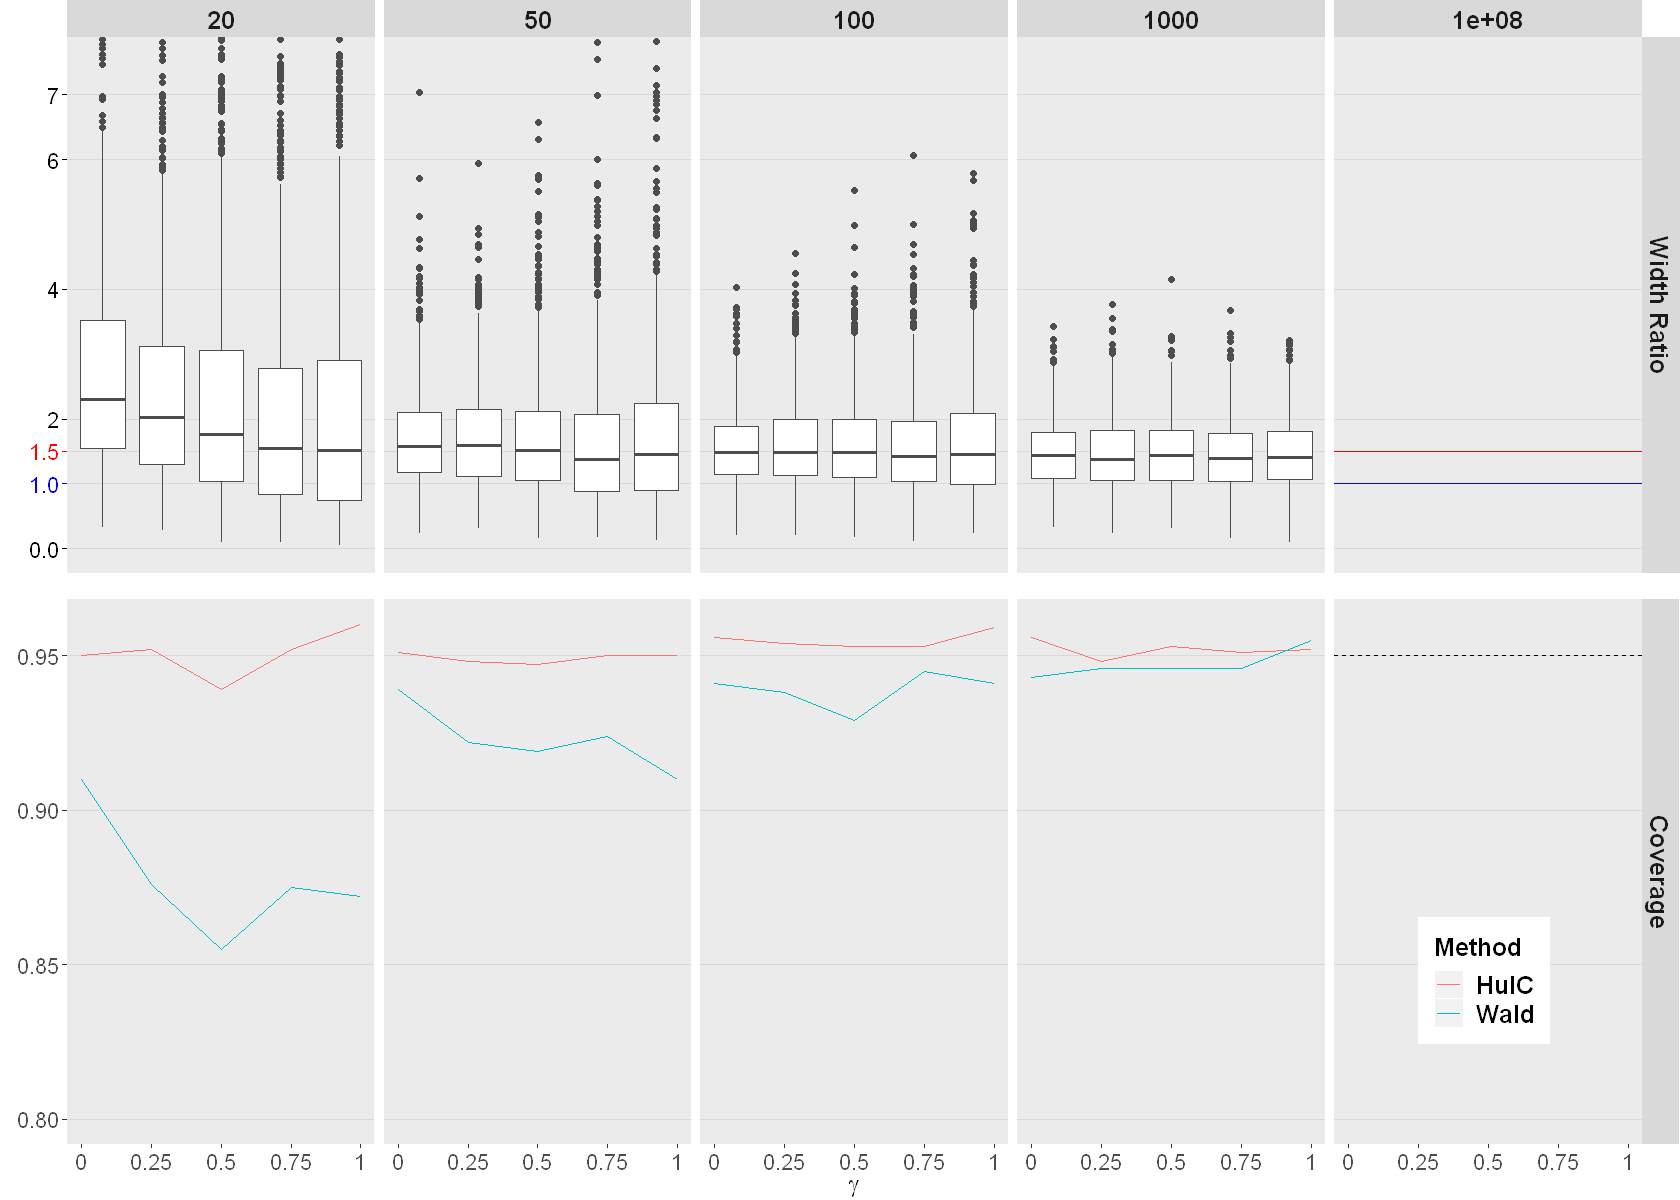

In [57]:
g1 <- ggplot(data = tmp_width_mat, mapping= aes(x=as.factor(gamma), y =value)) +
  geom_boxplot(color="gray30")+ 
  facet_grid(type~as.factor(nsamp))  + 
  geom_hline(yintercept = 1.5, linetype = 1, color = "red")+ 
  scale_x_discrete(labels = NULL, breaks = NULL) + 
  labs(x = "",y="")+
  theme(plot.margin=unit(c(0,0,0,.05), "cm"))+ 
  coord_cartesian(ylim=c(0, 7.5))+background_grid(major="y", minor="none")
g1 <- g1 + geom_hline(yintercept=1,color="blue")
g1 <- g1 + scale_y_continuous(breaks=c(0, 1, 1.5, 2, 4, 6, 7), 
                    labels=c("0.0", "1.0", "1.5", "2", "4", "6", "7"))
g1 <- g1 + theme(axis.text.x=element_text(size = 13),
                axis.text.y=element_text(size=13,color = c("black", "blue", "red", "black", "black", "black", "black")),
                axis.text=element_text(size=12),
                axis.title=element_text(size=15,face="bold"),
                strip.text = element_text(size=15,face = "bold"),
                axis.ticks.y = element_line(color = c("black", "blue", "red", "black", "black", "black", "black"),
                                    size = c(.5,0.5,0.5,.5,.5,.5,.5)))


levels(col.cov$name)[1] <- "HulC"
g2<-ggplot(data= col.cov, mapping= aes(x=gamma, y =cov, col=name, group= as.factor(name))) +
  ylim(.8, 0.96)+
  geom_line()+ 
  facet_grid(type~as.factor(nsamp)) + 
  geom_hline(yintercept = 0.95, linetype = 2) + 
  theme(plot.margin=unit(c(0,0,0,-.2), "cm"),
        legend.position=c(0.9,0.3),
        strip.background.x = element_blank(),
        legend.margin = margin(10, 10, 10, 10),
        axis.text.x=element_text(size = 13),
        axis.text.y=element_text(size=13),
        axis.text=element_text(size=12),
        legend.text=element_text(size=15, face = "bold"),
        legend.title=element_text(size = 15, face = "bold"),
        strip.text.x = element_blank(),    
        axis.title=element_text(size=15,face="bold"),
        strip.text = element_text(size=15,face = "bold") )+ 
  labs(y="", x=expression(gamma))+
  background_grid(major="y", minor="none")+
  scale_color_discrete("Method")+
  scale_x_continuous(breaks=c(0, 0.25, 0.5, 0.75, 1), 
                      labels=c("0", "0.25", "0.5", "0.75", "1"))

options(repr.plot.width=14, repr.plot.height=10)
grid.arrange(g1,g2)